In [43]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import os
import glob
from functools import reduce
import quandl
from datetime import datetime
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor

from scipy import stats

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score



# Creating Explanatory Factor Models

## 1 Data Importing

The chosen equity fund is the SPY ETF.

1.1 Import 11 ETFs, which are the Select Spdrs (e.g. XLF, XLE, etc.).  Some of this period did not include the Real Estate sector fund.

In [108]:
# Set start and end dates
start_date = '2016-04-01'
end_date = '2019-12-01'

# Get the data for ETFs
funds = data.get_data_yahoo(["XLE","XLF","XLU","XLI","GDX","XLK","XLV","XLY","XLP","XLB","XOP","SPY"], start_date, end_date)['Close']
funds.head()

Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP,SPY
Date,,,,,,,,,,,,
2016-04-01,61.060001,18.440292,49.810001,55.730000,20.120001,44.700001,68.550003,79.430000,53.619999,45.240002,119.400002,206.919998
2016-04-04,60.610001,18.350933,49.599998,55.099998,19.530001,44.529999,69.370003,78.809998,53.639999,44.650002,117.919998,206.250000
2016-04-05,60.200001,18.090982,48.669998,54.759998,20.129999,44.099998,68.470001,78.139999,53.279999,44.369999,116.919998,204.190002
2016-04-06,61.500000,18.188465,48.610001,55.029999,20.150000,44.529999,70.309998,78.879997,53.700001,44.880001,120.879997,206.419998
2016-04-07,61.139999,17.847279,48.590000,54.500000,20.780001,43.889999,69.540001,77.989998,53.119999,44.230000,121.120003,203.949997


1.2. Import the data series corresponding to the Leading Economic Indicators (LEI), Coincidental Economic Indicators (CEI), and Lagging Economic Indicators (LAG).  Note: Some of these data series are weekly, some monthly, and some are quarterly.

In [109]:
#Export Data for Indicators
script_dir = os.path.dirname(os.path.realpath('__file__'))
leading_path = "Leading/*.csv"
coincident_path = "Coincident/*.csv"
lagging_path = "Lagging/*.csv"

#Leading indicators
all_files = glob.glob(os.path.join(script_dir, leading_path)) 
dfs_leading = []
for file in all_files:
    dfs_leading.append(pd.read_csv(file))
leading_ind = reduce(lambda df1,df2: pd.merge(df1,df2,on='DATE'), dfs_leading)
leading_ind = leading_ind[(leading_ind['DATE'] <= end_date) & (leading_ind['DATE'] >= start_date)].set_index('DATE')
leading_ind.index = pd.to_datetime(leading_ind.index)
leading_ind['SP500'] = leading_ind.SP500.astype(float)


#Lagging indicators
all_files = glob.glob(os.path.join(script_dir, lagging_path)) 
dfs_lagging = []
for file in all_files:
    dfs_lagging.append(pd.read_csv(file))
lagging_ind = reduce(lambda df1,df2: pd.merge(df1,df2,on='DATE'), dfs_lagging)
lagging_ind = lagging_ind[(lagging_ind['DATE'] <= end_date) & (lagging_ind['DATE'] >= start_date)].set_index('DATE')
lagging_ind.index = pd.to_datetime(lagging_ind.index)

#Coincident indicators
all_files = glob.glob(os.path.join(script_dir, coincident_path)) 
dfs_coincident = []
for file in all_files:
    dfs_coincident.append(pd.read_csv(file))
coincident_ind = reduce(lambda df1,df2: pd.merge(df1,df2,on='DATE'), dfs_coincident)
coincident_ind = coincident_ind[(coincident_ind['DATE'] <= end_date) & (coincident_ind['DATE'] >= start_date)].set_index('DATE')
coincident_ind.index = pd.to_datetime(coincident_ind.index)

In [110]:
leading_ind = reduce(lambda df1,df2: pd.merge(df1,df2,on='DATE'), dfs_leading)
leading_ind = leading_ind[(leading_ind['DATE'] <= end_date) & (leading_ind['DATE'] >= start_date)].set_index('DATE')
leading_ind.index = pd.to_datetime(leading_ind.index)
leading_ind['SP500'] = leading_ind.SP500.astype(float)


#Lagging indicators
all_files = glob.glob(os.path.join(script_dir, lagging_path)) 
dfs_lagging = []
for file in all_files:
    dfs_lagging.append(pd.read_csv(file))
lagging_ind = reduce(lambda df1,df2: pd.merge(df1,df2,on='DATE'), dfs_lagging)
lagging_ind = lagging_ind[(lagging_ind['DATE'] <= end_date) & (lagging_ind['DATE'] >= start_date)].set_index('DATE')
lagging_ind.index = pd.to_datetime(lagging_ind.index)

#Coincident indicators
all_files = glob.glob(os.path.join(script_dir, coincident_path)) 
dfs_coincident = []
for file in all_files:
    dfs_coincident.append(pd.read_csv(file))
coincident_ind = reduce(lambda df1,df2: pd.merge(df1,df2,on='DATE'), dfs_coincident)
coincident_ind = coincident_ind[(coincident_ind['DATE'] <= end_date) & (coincident_ind['DATE'] >= start_date)].set_index('DATE')
coincident_ind.index = pd.to_datetime(coincident_ind.index)

In [111]:
leading_ind.head()


,ACOGNO,AWHAEMAN,CCI,ICNSA,ISM,NEWORDER,PERMIT,SP500,T10YFF,USSLIND
DATE,,,,,,,,,,
2016-04-01,178929.0,40.8,100.6114,249257.20,55.8,60168.0,1155.0,2065.30,1.53,1.56
2016-05-01,179537.0,40.8,100.7484,248576.50,55.7,58923.0,1198.0,2096.96,1.55,1.43
2016-06-01,184188.0,40.7,100.7237,252551.75,57.0,59059.0,1204.0,2098.86,1.19,1.45
2016-07-01,181207.0,40.7,100.5595,257152.60,56.9,59333.0,1193.0,2173.60,1.16,1.50
2016-08-01,181998.0,40.7,100.4409,220952.75,49.1,60984.0,1203.0,2170.95,1.28,1.54


In [112]:
lagging_ind.head()

,CUSR0000SAS,DPRIME,MNFCTRIRSA,TDSP,TOTCI,UEMPMEAN,ULCMFG
DATE,,,,,,,
2016-04-01,297.918,3.50,1.42,9.886104,2032.056225,27.9,107.728
2016-07-01,300.499,3.50,1.41,9.943416,2058.958700,27.8,108.033
2016-10-01,302.528,3.50,1.40,9.911939,2083.630350,26.6,108.910
2017-01-01,304.837,3.75,1.38,9.860390,2081.532975,25.4,110.071
2017-04-01,306.295,4.00,1.39,9.828715,2066.105250,23.9,110.765


In [113]:
coincident_ind.head()

,CMRMTSPL,INDPRO,PAYEMS,W875RX1
DATE,,,,
2016-04-01,1406605.0,101.5167,143851,12792.1
2016-05-01,1398379.0,101.4298,143892,12786.7
2016-06-01,1406063.0,101.8747,144150,12803.0
2016-07-01,1405965.0,102.1325,144521,12850.4
2016-08-01,1415004.0,102.0407,144664,12853.6


## 2. Data Processing

Because some of the data is quarterly (coincident indicators) we compute returns both monthly and quarterly. For that we need to resample the data accordingly.

In [114]:
mth_returns = funds.groupby(pd.Grouper(freq='M')).nth(0)
mth_returns.index = mth_returns.index.shift(-1,'M')
mth_returns.index = mth_returns.index.shift(1,'D')
mth_returns.head()

Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP,SPY
Date,,,,,,,,,,,,
2016-04-01,61.060001,18.440292,49.810001,55.730000,20.120001,44.700001,68.550003,79.430000,53.619999,45.240002,119.400002,206.919998
2016-05-01,67.430000,19.106419,48.810001,56.450001,25.389999,42.439999,70.190002,80.309998,52.900002,47.270000,141.880005,207.970001
2016-06-01,66.889999,19.333876,49.279999,55.970001,22.719999,44.080002,71.610001,79.190002,53.200001,47.000000,143.639999,210.270004
2016-07-01,68.599998,18.472786,52.480000,56.189999,29.049999,43.470001,72.160004,78.870003,54.889999,46.360001,141.600006,209.919998
2016-08-01,65.160004,19.163282,52.150002,57.970001,30.930000,46.540001,75.680000,81.750000,54.759998,48.419998,131.039993,216.940002


In [115]:
qtr_returns = funds.groupby(pd.Grouper(freq='Q')).nth(0).pct_change().dropna()
qtr_returns.index = qtr_returns.index.shift(-1,'Q')
qtr_returns.index = qtr_returns.index.shift(1,'D')
qtr_returns.head()

Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP,SPY
Date,,,,,,,,,,,,
2016-07-01,0.123485,0.001762,0.053604,0.008254,0.443837,-0.027517,0.052662,-0.007050,0.023685,0.024757,0.185930,0.014498
2016-10-01,0.028571,0.039908,-0.079649,0.039865,-0.106368,0.095928,-0.001524,0.014201,-0.036801,0.028688,0.088701,0.027915
2017-01-01,0.079507,0.223842,0.003106,0.071196,-0.161787,0.024139,-0.030673,0.023628,-0.018347,0.048228,0.090036,0.043841
2017-04-01,-0.083891,0.007231,0.058823,0.037226,0.066176,0.091617,0.065578,0.069858,0.049904,0.044409,-0.112354,0.044797
2017-07-01,-0.051734,0.057010,0.008187,0.055607,-0.074138,0.020278,0.066649,0.022146,0.007341,0.039648,-0.125503,0.029236


We need to do the same for the other economic indicators:

In [116]:
#For leading Indicators
qtr_leading_ind = leading_ind.groupby(pd.Grouper(freq='Q')).nth(0)
qtr_leading_ind.index = qtr_leading_ind.index.shift(-1,'Q')
qtr_leading_ind.index = qtr_leading_ind.index.shift(1,'D')
qtr_leading_ind

,ACOGNO,AWHAEMAN,CCI,ICNSA,ISM,NEWORDER,PERMIT,SP500,T10YFF,USSLIND
DATE,,,,,,,,,,
2016-04-01,178929.0,40.8,100.6114,249257.20,55.8,60168.0,1155.0,2065.30,1.53,1.56
2016-07-01,181207.0,40.7,100.5595,257152.60,56.9,59333.0,1193.0,2173.60,1.16,1.50
2016-10-01,184665.0,40.8,100.5056,231147.00,52.1,59052.0,1271.0,2126.15,1.53,1.27
2017-01-01,191247.0,40.7,101.4177,333138.50,60.4,61202.0,1313.0,2278.87,1.89,1.73
2017-04-01,189927.0,40.7,101.3254,225320.00,57.5,61763.0,1255.0,2384.20,1.46,1.59
2017-07-01,190484.0,40.9,101.0813,242841.80,60.4,61558.0,1265.0,2470.30,1.23,1.43
2017-10-01,198225.0,40.9,101.4919,216703.50,63.5,63801.0,1339.0,2575.26,1.31,1.59
2018-01-01,204437.0,40.7,101.4099,321816.75,65.4,62956.0,1365.0,2823.81,1.38,1.55
2018-04-01,206719.0,41.1,101.6434,211109.75,61.2,64637.0,1387.0,2648.05,1.26,1.59


In [117]:
#For coincident indicators
qtr_coincident_ind = coincident_ind.groupby(pd.Grouper(freq='Q')).nth(0)
qtr_coincident_ind.index = qtr_coincident_ind.index.shift(-1,'Q')
qtr_coincident_ind.index = qtr_coincident_ind.index.shift(1,'D')
qtr_coincident_ind

,CMRMTSPL,INDPRO,PAYEMS,W875RX1
DATE,,,,
2016-04-01,1406605.0,101.5167,143851,12792.1
2016-07-01,1405965.0,102.1325,144521,12850.4
2016-10-01,1421561.0,102.2485,145071,12919.9
2017-01-01,1433704.0,103.0366,145612,13036.6
2017-04-01,1427873.0,104.2721,146154,13179.6
2017-07-01,1442505.0,104.5427,146734,13323.2
2017-10-01,1464552.0,105.6287,147215,13449.2
2018-01-01,1468558.0,106.2655,147671,13560.5
2018-04-01,1470363.0,108.2223,148397,13644.7


## 3. Category Models: Linear Regression

### 3.1 Regression on the LEI

First we define the weigths for the different indicators

In [118]:
leading_ind.columns

Index(['ACOGNO', 'AWHAEMAN', 'CCI', 'ICNSA', 'ISM', 'NEWORDER', 'PERMIT',
       'SP500', 'T10YFF', 'USSLIND'],
      dtype='object')

In [119]:
#Define Weights
leading_weights = [0.0844,0.2798,0.1410,0.0326,0.1587,0.0411,0.0289,0.0393,0.1109,0.0833]
sum(leading_weights)

1.0

**Regression**

All indicators have a monthly frequency so we can use monthly returns.

In [120]:
#Regression
X = leading_ind.mul(leading_weights).iloc[:-1,:]
#Create empty df to store results
results_etf_lei = pd.DataFrame(columns = ['coefs','score','mse'], index = pd.MultiIndex.from_product([['LEI'],mth_returns.columns]))

#Loop over ETFs
for column in mth_returns.columns:
    y = mth_returns[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle = False)
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    predictions = linreg.predict(X_test)
    
    #Get Results
    results_etf_lei.loc[('LEI',column),'score'] = linreg.score(X_test,y_test)
    results_etf_lei.loc[('LEI',column),'coefs'] = linreg.coef_
    results_etf_lei.loc[('LEI',column),'mse'] = mean_squared_error(y_test,predictions)
    
results_etf_lei.sort_values(['score','mse'], ascending = False)

coefs      score  \
    Symbols                                                                 
LEI XLK      [0.003889823168008849, 12.617256249698745, -12...  0.0948144   
    GDX      [-0.0015882019211777283, -20.319459103235314, ...  0.0438897   
    SPY      [0.0025647436066837483, 32.82275711591953, 6.7... -0.0234417   
    XLY      [0.005875543503329272, 15.817608096179276, -13...  -0.105958   
    XLI      [-0.0016062668778164487, 26.69204738355793, 26...   -0.19269   
    XLU      [-0.006053796504675265, 4.8628130717444105, -0...  -0.297895   
    XLF      [-0.0002365366503328008, 4.351429897604222, 25...  -0.587755   
    XLP      [-0.0066374211663409255, 5.558127481847724, -5...  -0.829269   
    XLE      [0.011181975409733216, -49.51658719477801, -48...   -1.06844   
    XOP      [0.047788113732737454, -212.75292414601967, -1...   -1.45582   
    XLB      [-0.0014544605679142105, 11.51022583308454, 13...   -2.55183   
    XLV      [-0.0020899443330338187, 13.330265906522447, -...   -4.39661   

                 mse  
    Symbols           
LEI XLK      30.7937  
    GDX      12.9319  
    SPY       177.41  
    XLY      40.7723  
    XLI      16.4004  
    XLU      20.8688  
    XLF       2.1849  
    XLP       17.661  
    XLE      65.3343  
    XOP      1788.56  
    XLB      18.4086  
    XLV      43.1379

### 3.2 Regression on the CEI

First we define the weigths for the different indicators

In [121]:
coincident_ind.columns

Index(['CMRMTSPL', 'INDPRO', 'PAYEMS', 'W875RX1'], dtype='object')

In [122]:
#Define Weights
coincident_weights = [0.1200,0.1446,0.5302,0.2052]
sum(coincident_weights)

1.0

**Regression**

All indicators have a monthly frequency so we can use monthly returns.

In [123]:
#Regression
X = coincident_ind.mul(coincident_weights,axis = 1).iloc[:-1,:]
#Create empty df to store results
results_etf_cei = pd.DataFrame(columns = ['coefs','score','mse'], index = pd.MultiIndex.from_product([['CEI'],mth_returns.columns]))

#Loop over ETFs
for column in mth_returns.columns:
    y = mth_returns[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle = False)
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    predictions = linreg.predict(X_test)
    
    #Get Results
    results_etf_cei.loc[('CEI',column),'score'] = linreg.score(X_test,y_test)
    results_etf_cei.loc[('CEI',column),'coefs'] = linreg.coef_
    results_etf_cei.loc[('CEI',column),'mse'] = mean_squared_error(y_test,predictions)
    
    
results_etf_cei.sort_values(['score','mse'], ascending = False)

coefs      score  \
    Symbols                                                                 
CEI GDX      [-0.0001263272113435661, -2.0605257635791854, ...   0.310195   
    XLK      [0.00014300573255774694, 2.2877846856685715, -...  0.0310596   
    SPY      [0.0008441406209115343, -8.364740841300987, -0...  -0.316739   
    XLY      [-0.001034232338658336, 14.215670137812742, 0....  -0.401101   
    XLV      [0.00014151710074940634, -1.6876165939232148, ...   -2.77619   
    XLI      [0.0005986971254531299, -7.389197309573322, -0...   -2.83273   
    XLU      [0.0001669460263323138, -6.472481653860565, -0...   -4.02737   
    XLP      [-0.00025959268971657314, -8.894638066160164, ...   -4.42166   
    XOP      [0.0021875377157155483, 52.679204923566225, 0....   -4.90579   
    XLE      [0.0006735481278387804, 7.162360749117723, 0.0...   -8.00691   
    XLB      [0.0007019513842397214, -8.052556278583083, -0...   -8.76881   
    XLF      [0.0004022571328044008, -5.433689905490187, -0...   -14.9865   

                 mse  
    Symbols           
CEI GDX      9.32997  
    XLK      32.9626  
    SPY      228.252  
    XLY       51.653  
    XLV      30.1851  
    XLI       52.703  
    XLU      80.8348  
    XLP      52.3444  
    XOP      4301.17  
    XLE      284.494  
    XLB      50.6301  
    XLF       21.999

### 3.3 Regression on LAG


In [124]:
lagging_ind.columns

Index(['CUSR0000SAS', 'DPRIME', 'MNFCTRIRSA', 'TDSP', 'TOTCI', 'UEMPMEAN',
       'ULCMFG'],
      dtype='object')

In [125]:
lagging_weights = [0.2113,0.3055,0.1282,0.1842,0.0844,0.0356,0.0508]
sum(lagging_weights)

0.9999999999999999

**Regression**

Lagging indicators are defined quarterly so we have to use quarterly returns.

In [126]:
#Regression
X = lagging_ind.mul(lagging_weights, axis = 1).iloc[:-1,:]
#Create empty df to store results
results_etf_lag = pd.DataFrame(columns = ['coefs','score','mse'], index = pd.MultiIndex.from_product([['LAG'],mth_returns.columns]))

#Loop over ETFs
for column in qtr_returns.columns:
    y = qtr_returns[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle = False)
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    predictions = linreg.predict(X_test)
    
    #Get Results
    results_etf_lag.loc[('LAG',column),'score'] = linreg.score(X_test,y_test)
    results_etf_lag.loc[('LAG',column),'coefs'] = linreg.coef_
    results_etf_lag.loc[('LAG',column),'mse'] = mean_squared_error(y_test,predictions)
    
    
results_etf_lag.sort_values(['score','mse'], ascending = False)

coefs    score  \
    Symbols                                                               
LAG XLI      [-0.12706622056750505, 0.030568574544871132, 1... -9.81253   
    XLV      [-0.3560642514653964, 1.5993530860881502, -36.... -10.4712   
    XLK      [-0.25310272096174363, 2.279683688048133, -56.... -19.5393   
    XLY      [-0.22022109150656974, 0.8223158331781427, -21... -25.2031   
    GDX      [-1.5082882131298028, 4.0628068629209855, -91.... -29.5861   
    SPY      [-0.27949200205867397, 0.8936628352475222, -5.... -32.4619   
    XLP      [-0.40118107911466605, 0.893942201894581, -25....  -37.871   
    XLU      [-0.6074865609233192, 0.8954282763829254, -29.... -65.8955   
    XLB      [-0.4443360557946473, 1.3825711021016536, -3.4... -97.0295   
    XLF      [-0.07622042140294928, -2.0154847271827507, 92... -98.8346   
    XOP      [-0.7737783882649096, 2.888583009179676, 67.79... -126.226   
    XLE      [-0.5679663532073778, 1.3844238319816897, 69.3... -126.546   

                   mse  
    Symbols             
LAG XLI       0.163524  
    XLV      0.0888643  
    XLK       0.329598  
    XLY       0.256837  
    GDX       0.355197  
    SPY       0.302548  
    XLP       0.120311  
    XLU       0.145983  
    XLB       0.647479  
    XLF       0.635934  
    XOP        4.20774  
    XLE        2.06813

### 3.4 Regression on all factors


**Regression**

Lagging indicators are defined quarterly so we have to use quarterly returns.

In [127]:
#Regression
X = pd.concat([qtr_leading_ind.mul(leading_weights, axis = 1).iloc[:-1,:],qtr_coincident_ind.mul(coincident_weights,axis = 1).iloc[:-1,:],lagging_ind.mul(lagging_weights, axis = 1).iloc[:-1,:]], axis =1)
#Create empty df to store results
results_etf_all = pd.DataFrame(columns = ['coefs','score','mse'],index = pd.MultiIndex.from_product([['ALL'],mth_returns.columns]))

#Loop over ETFs
for column in qtr_returns.columns:
    y = qtr_returns[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle = False)
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    predictions = linreg.predict(X_test)
    
    #Get Results
    results_etf_all.loc[('ALL',column),'score'] = linreg.score(X_test,y_test)
    results_etf_all.loc[('ALL',column),'coefs'] = linreg.coef_
    results_etf_all.loc[('ALL',column),'mse'] = mean_squared_error(y_test,predictions)
    
    
results_etf_all.sort_values(['score','mse'], ascending = False)

coefs      score  \
    Symbols                                                                 
ALL XLV      [-3.036491563198747e-05, -3.1120269706653315e-...  0.0129777   
    XLP      [-9.192149198207765e-05, -8.674374523319685e-0...  -0.430988   
    XLI      [-0.00013426310035750957, -0.00022670438922631...  -0.910933   
    SPY      [-0.00016474771061720817, 0.000170532186368115...   -5.83207   
    XLB      [-0.0002423041588793988, 0.0001484785336437667...   -9.72511   
    XLE      [-0.00011942668404130384, 0.000949045635684954...   -13.2113   
    XLY      [-0.0001607361613117888, 0.0002435336975482894...   -16.0259   
    XLF      [0.000135666314659005, -0.0005124379544887068,...   -18.3435   
    XLK      [-0.0005393800585159856, 0.0007164565575791137...   -40.6652   
    XOP      [-0.00037504099329190217, 0.002040812621916106...   -42.8709   
    GDX      [8.544500780924981e-06, 0.0006485396743520556,...    -44.288   
    XLU      [0.00017996390980182445, -7.20615623292853e-05...   -51.5887   

                    mse  
    Symbols              
ALL XLV      0.00764618  
    XLP      0.00442911  
    XLI       0.0289001  
    SPY       0.0617726  
    XLB       0.0708387  
    XLE        0.230434  
    XLY        0.166884  
    XLF        0.123216  
    XLK        0.668609  
    XOP         1.45094  
    GDX        0.525929  
    XLU        0.114762

### 3.6 Results Comparison

In [128]:
#Predicting power
all_results = pd.concat([results_etf_lei,results_etf_cei, results_etf_lag, results_etf_all]).reset_index()
all_results[all_results.groupby(['Symbols'])['score'].transform(max) == all_results['score']].sort_values('score', ascending = False)

,level_0,Symbols,coefs,score,mse
16,CEI,GDX,"[-0.0001263272113435661, -2.0605257635791854, ...",0.310195,9.32997
5,LEI,XLK,"[0.003889823168008849, 12.617256249698745, -12...",0.0948144,30.7937
42,ALL,XLV,"[-3.036491563198747e-05, -3.1120269706653315e-...",0.0129777,0.00764618
11,LEI,SPY,"[0.0025647436066837483, 32.82275711591953, 6.7...",-0.0234417,177.41
7,LEI,XLY,"[0.005875543503329272, 15.817608096179276, -13...",-0.105958,40.7723
3,LEI,XLI,"[-0.0016062668778164487, 26.69204738355793, 26...",-0.19269,16.4004
2,LEI,XLU,"[-0.006053796504675265, 4.8628130717444105, -0...",-0.297895,20.8688
44,ALL,XLP,"[-9.192149198207765e-05, -8.674374523319685e-0...",-0.430988,0.00442911
1,LEI,XLF,"[-0.0002365366503328008, 4.351429897604222, 25...",-0.587755,2.1849
0,LEI,XLE,"[0.011181975409733216, -49.51658719477801, -48...",-1.06844,65.3343


The LEI indicators seem to returns the best scores for most ETF with the highest score for the GDX ETF. Only the XLB and the XLV ETFs are better explained by models using different indicators (CEI and all indicators respectively). Adding more indicators doesn't seem to improve the explanatory power of the model adn the LEI indicators seem to be those that explain best the variation of the ETFs returns.

## 4. Model Selection

The answer for the question 4.1 was given above.

## 5. Category 2 Models: Lasso

### 5.1. Lasso Regression

In [129]:
#Regression
X = pd.concat([qtr_leading_ind.mul(leading_weights, axis = 1).iloc[:-1,:],qtr_coincident_ind.mul(coincident_weights,axis = 1).iloc[:-1,:],lagging_ind.mul(lagging_weights, axis = 1).iloc[:-1,:]], axis =1)
#Create empty df to store results
alphas = np.linspace(0.9,1, 1001)[1:]
results_etf_lasso = pd.DataFrame(columns = ['coefs','nb_predictors','score','mse'], index =pd.MultiIndex.from_product([['LASSO'],qtr_returns.columns]))

#Loop over ETFs
for column in qtr_returns.columns:
    #Define variables and split dataset
    y = qtr_returns[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle = False)
        
    #Fit Lasso
    lasso = Lasso(max_iter = 1000)
    lasso.fit(X_train,y_train)
    predictions = lasso.predict(X_test)

    #Get Results
    results_etf_lasso.loc[('LASSO',column),'score'] = linreg.score(X_test,y_test)
    results_etf_lasso.loc[('LASSO',column),'coefs'] = linreg.coef_
    results_etf_lasso.loc[('LASSO',column),'nb_predictors'] = np.sum(lasso.coef_!=0)
    results_etf_lasso.loc[('LASSO',column),'mse'] = mean_squared_error(y_test,predictions)
    
results_etf_lasso.sort_values(['score','mse','nb_predictors'], ascending = False)   

coefs  \
      Symbols                                                      
LASSO XLK      [-0.00016474771061720817, 0.000170532186368115...   
      XLI      [-0.00016474771061720817, 0.000170532186368115...   
      GDX      [-0.00016474771061720817, 0.000170532186368115...   
      XOP      [-0.00016474771061720817, 0.000170532186368115...   
      XLE      [-0.00016474771061720817, 0.000170532186368115...   
      XLY      [-0.00016474771061720817, 0.000170532186368115...   
      SPY      [-0.00016474771061720817, 0.000170532186368115...   
      XLV      [-0.00016474771061720817, 0.000170532186368115...   
      XLF      [-0.00016474771061720817, 0.000170532186368115...   
      XLB      [-0.00016474771061720817, 0.000170532186368115...   
      XLP      [-0.00016474771061720817, 0.000170532186368115...   
      XLU      [-0.00016474771061720817, 0.000170532186368115...   

              nb_predictors    score         mse  
      Symbols                                     
LASSO XLK                 3 -2.60002   0.0205619  
      XLI                 3 -3.45069   0.0157127  
      GDX                 5 -3.66508   0.0686073  
      XOP                 4 -3.76832   0.0933079  
      XLE                 3 -5.09769   0.0349441  
      XLY                 2 -5.12813   0.0181839  
      SPY                 2 -5.83207   0.0120217  
      XLV                 3 -8.06031  0.00820581  
      XLF                 4 -9.23218  0.00897986  
      XLB                 3 -9.45224  0.00912436  
      XLP                 3 -14.8876  0.00739951  
      XLU                 2 -19.4365  0.00331127

### 5.2 Compare and Contrast

In [130]:
all_results = pd.concat([all_results, results_etf_lasso.reset_index()])
all_results[all_results.groupby(['Symbols'])['score'].transform(max) == all_results['score']].sort_values('score', ascending = False)

,level_0,Symbols,coefs,score,mse,nb_predictors
16,CEI,GDX,"[-0.0001263272113435661, -2.0605257635791854, ...",0.310195,9.32997,NaN
5,LEI,XLK,"[0.003889823168008849, 12.617256249698745, -12...",0.0948144,30.7937,NaN
42,ALL,XLV,"[-3.036491563198747e-05, -3.1120269706653315e-...",0.0129777,0.00764618,NaN
11,LEI,SPY,"[0.0025647436066837483, 32.82275711591953, 6.7...",-0.0234417,177.41,NaN
7,LEI,XLY,"[0.005875543503329272, 15.817608096179276, -13...",-0.105958,40.7723,NaN
3,LEI,XLI,"[-0.0016062668778164487, 26.69204738355793, 26...",-0.19269,16.4004,NaN
2,LEI,XLU,"[-0.006053796504675265, 4.8628130717444105, -0...",-0.297895,20.8688,NaN
44,ALL,XLP,"[-9.192149198207765e-05, -8.674374523319685e-0...",-0.430988,0.00442911,NaN
1,LEI,XLF,"[-0.0002365366503328008, 4.351429897604222, 25...",-0.587755,2.1849,NaN
0,LEI,XLE,"[0.011181975409733216, -49.51658719477801, -48...",-1.06844,65.3343,NaN


The conclusions are similar. For most fund, using only the LEI indicators returns a better performance. Only the XOP ETF see an improved performance using a LASSO regression with 4 predictors. One thing to bear in mind is that even though LASSO regressions might show less predicting power, they are often simpler models and therefore require more data. Considering the fact that the data is taken quarterly, it can be a good idea to choose a model that is more parsimonious.

## 6. Category 3 Models: Cluster Analysis

### 6.1. Cluster Analysis

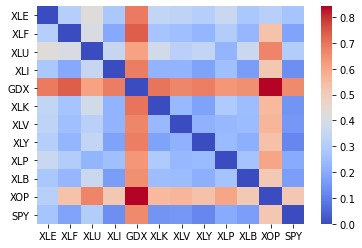

In [131]:
returns = funds.pct_change().dropna()
euclidean_distances_matrix = euclidean_distances(returns.T,returns.T)
sns.heatmap(euclidean_distances_matrix, xticklabels=funds.columns,
            yticklabels=funds.columns, cmap="coolwarm")

In [132]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(returns)
returns['Cluster'] = kmeans.labels_
kmeans.cluster_centers_

array([[-0.00393528, -0.00100872,  0.00052894, -0.00110223, -0.00124173,
        -0.0005797 , -0.00062592, -0.00078101, -0.00024868, -0.00176888,
        -0.00757536, -0.00088885],
       [-0.02137364, -0.01959854, -0.0030952 , -0.01950823,  0.00354019,
        -0.0214561 , -0.01529228, -0.01837763, -0.00957652, -0.01860182,
        -0.03185537, -0.01763036],
       [ 0.01134531,  0.00756228,  0.00058892,  0.00734113,  0.00292731,
         0.00782474,  0.00557438,  0.00668758,  0.00297241,  0.00797956,
         0.0190857 ,  0.00664331]])

### 6.2. Compare and Contrast

The problems addressed in the previous parts are different from this one. Here we evaluate 3 clusters for the data on the ETF's returns while in the previous parts we try to find the model that best predicts the fluctuations of each individual returns. For this reason it does not make sense to compare the models.

## 7. Category 4 Models: Tree

### 7.1. Regression Tree

In [133]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, accuracy_scores, '-*', label='accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xticks(depths)
    ax.legend()

In [134]:
X = pd.concat([qtr_leading_ind.mul(leading_weights, axis = 1).iloc[:-1,:],qtr_coincident_ind.mul(coincident_weights,axis = 1).iloc[:-1,:],lagging_ind.mul(lagging_weights, axis = 1).iloc[:-1,:]], axis =1)
#Create empty df to store results
results_etf_tree = pd.DataFrame(columns = ['score','nmse'], index = pd.MultiIndex.from_product([['TREE'],qtr_returns.columns]))

#Loop over ETFs
for column in qtr_returns.columns:
    y = qtr_returns[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    tree_model = DecisionTreeRegressor(max_depth=3).fit(X_train,y_train)
    results_etf_tree.loc[('TREE',column),'nmse'] = cross_val_score(tree_model, X, y, cv=10, scoring='neg_mean_squared_error').mean()
    results_etf_tree.loc[('TREE',column),'score'] = tree_model.score(X_test, y_test)

results_etf_tree.sort_values(['score','nmse'], ascending = False)   

score        nmse
     Symbols                      
TREE XOP      0.634156  -0.0632301
     XLF     -0.123766   -0.013455
     XLV     -0.399215  -0.0200923
     GDX      -1.00994  -0.0289979
     XLY        -1.444  -0.0121531
     XLK      -4.63806  -0.0320894
     XLE        -8.409   -0.031779
     XLP      -10.1005 -0.00521822
     SPY      -10.4513  -0.0182631
     XLI      -11.5281  -0.0181449
     XLB      -14.4013     -0.0141
     XLU      -14.4061 -0.00384559

### 7.2 Compare and Contrast

In [135]:
all_results = pd.concat([all_results, results_etf_tree.reset_index()])
all_results[all_results.groupby(['Symbols'])['score'].transform(max) == all_results['score']].sort_values('score', ascending = False)

,level_0,Symbols,coefs,score,mse,nb_predictors,nmse
10,TREE,XOP,NaN,0.634156,NaN,NaN,-0.0632301
16,CEI,GDX,"[-0.0001263272113435661, -2.0605257635791854, ...",0.310195,9.32997,NaN,NaN
5,LEI,XLK,"[0.003889823168008849, 12.617256249698745, -12...",0.0948144,30.7937,NaN,NaN
42,ALL,XLV,"[-3.036491563198747e-05, -3.1120269706653315e-...",0.0129777,0.00764618,NaN,NaN
11,LEI,SPY,"[0.0025647436066837483, 32.82275711591953, 6.7...",-0.0234417,177.41,NaN,NaN
7,LEI,XLY,"[0.005875543503329272, 15.817608096179276, -13...",-0.105958,40.7723,NaN,NaN
1,TREE,XLF,NaN,-0.123766,NaN,NaN,-0.013455
3,LEI,XLI,"[-0.0016062668778164487, 26.69204738355793, 26...",-0.19269,16.4004,NaN,NaN
2,LEI,XLU,"[-0.006053796504675265, 4.8628130717444105, -0...",-0.297895,20.8688,NaN,NaN
44,ALL,XLP,"[-9.192149198207765e-05, -8.674374523319685e-0...",-0.430988,0.00442911,NaN,NaN


Again the performance is usually better for LEI indicators as only explantory variables. Here again the XOP ETFs gets improved performance from the new model (Regression Tree).